In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [169]:
df = pd.read_pickle('../Data Files/merged.pkl')
print(df.shape)
df.head()

(1016, 21)


,category,channelId,channelTitle,classification,commentCount,comments,commonMal,completeDomains,description,domains,...,links,linksCount,linksDown,linksDownCount,linksUp,redirectedDomains,tags,title,videoId,viewCount
0,People & Blogs,UCFqanUMpCMh54RmqRFh8hZw,ProfitClicksDelux,f,240.0,[Well I found free $3421a money making system ...,0.0,NaN,After months of searching for a constant onlin...,NaN,...,"[http://www.neobux.com/?r=dirven, http://imgur...",2.0,"[[http://www.neobux.com/?r=dirven, HTTP error]]",1,[https://imgur.com/NcIH1y8],NaN,"[Money (TV Episode), How-to (Media Genre), Bus...",How to make money online just by clicking ads ...,https://www.youtube.com/watch?v=dFotOUq0Z4E,296630.0
1,Autos & Vehicles,UCfed0SJsJPmv-TTlZfHFWpA,TeCHnical sHarma,f,NaN,No comments,0.0,NaN,Hello à¤¦à¥‹à¤¸à¥�à¤¤à¥‹à¤‚ ðŸ˜ŠðŸ˜Š\n\nPlease...,NaN,...,[https://play.google.com/store/apps/details?id...,3.0,[],0,[https://play.google.com/store/apps/details?id...,NaN,"[Earn Free Money, Make Money with Android App,...",Earn Money by Clicking On own Android App. Ea...,https://www.youtube.com/watch?v=nz7Fs7YPCIM,169662.0
2,How-to & Style,UCj2zirDn1hkPKSARbARfeQw,iampauljames,b,242.0,"[Great job Sir!, Paul is it hard to get approv...",0.0,NaN,IM Report 360 outlines exactly how you can mak...,NaN,...,No links,0.0,[],0,[],NaN,"[Make Money Online, Pay Per Click, Affiliate]",Make Money Online With No Website Using Pay Pe...,https://www.youtube.com/watch?v=JYVTcpIXi_4,206170.0
3,How-to & Style,UCRfWuSls0R7jQazuddXiPvQ,Tyler Pratt,f,8.0,"[Didn't work, The real big money?? LOL cl...",0.0,NaN,My #1 Recommendation To Earning Income Online ...,NaN,...,"[http://go.tylerpratt.com/, http://go.tylerpra...",9.0,[],0,"[https://go.tylerpratt.com/, https://go.tylerp...",NaN,"[make money online, tyler pratt, tylerpratt, e...",Easy Side Online Job Clicking Ads and Making M...,https://www.youtube.com/watch?v=H1KmFXp2Ymg,7104.0
4,People & Blogs,UC4l9z0a-bFvZyX1HAqn270A,Sevendollarclick.com,f,NaN,No comments,0.0,NaN,Click here to start making money: \nhttp://www...,NaN,...,"[http://www.sevendollarclick.com, https://www....",12.0,[],0,"[https://sevendollarclick.com/, https://www.yo...",NaN,"[how to make money, how to make money online, ...",Earn Money By Clicking Ads | Earn $7 Per Click...,https://www.youtube.com/watch?v=WBHBZMeywY4,53451.0


In [170]:
df.dtypes

category             category
channelId              object
channelTitle           object
classification       category
commentCount          float64
comments               object
commonMal             float64
completeDomains        object
description            object
domains                object
linkContent            object
links                  object
linksCount            float64
linksDown              object
linksDownCount         object
linksUp                object
redirectedDomains      object
tags                   object
title                  object
videoId                object
viewCount             float64
dtype: object

In [148]:
df.isna().sum()

category             190
channelId              0
channelTitle         191
classification         0
commentCount          39
comments               0
commonMal            465
completeDomains      551
description            0
domains              551
linkContent            0
links                190
linksCount           190
linksDown            190
linksDownCount       190
linksUp              190
redirectedDomains    741
tags                   0
title                  0
videoId                0
viewCount              1
dtype: int64

### histograms and counts

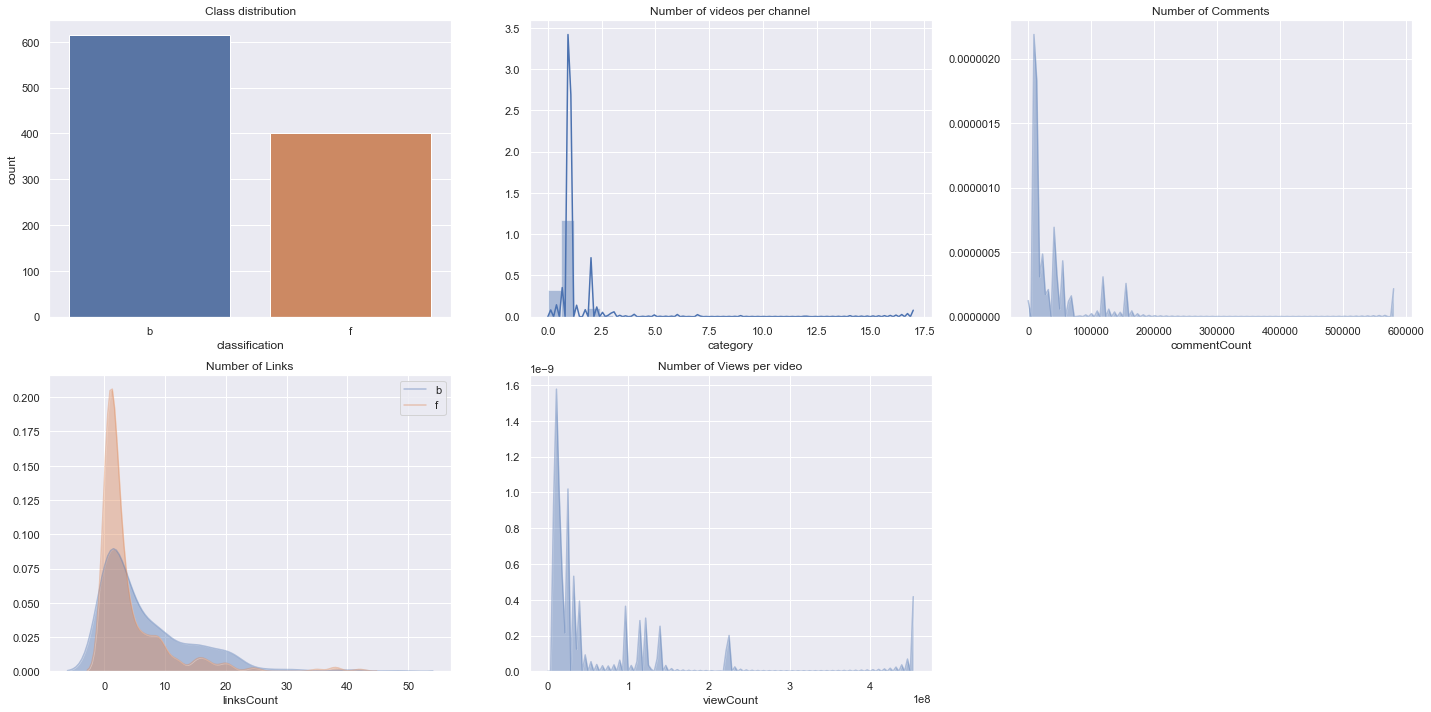

In [200]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
axes = axes.flatten()

sns.countplot(data=df, x='classification', ax=axes[0]);
axes[0].set_title('Class distribution');

sns.distplot(df.groupby('channelId').count()['category'], ax=axes[1])
axes[1].set_title('Number of videos per channel');

sns.distplot(df['commentCount'].dropna(), hist=False,
             kde_kws={'shade':True, 'alpha':0.4},
             ax=axes[2]);
axes[2].set_title('Number of Comments');

for label, label_df in df.groupby('classification'):
    sns.distplot(label_df['linksCount'].dropna(), hist=False, 
                 kde_kws={'shade':True, 'alpha':0.4},
                 label=label, ax=axes[3]);
axes[3].legend()
axes[3].set_title('Number of Links');

sns.distplot(df['viewCount'].dropna(), hist=False, 
             kde_kws={'shade':True, 'alpha':0.4}, 
             ax=axes[4]);
axes[4].set_title('Number of Views per video');

axes[5].set_visible(False)

plt.tight_layout()

### word frequencies

In [124]:
b_description = ' '.join(df[df['classification'] == 'b']['description'].values)
f_description = ' '.join(df[df['classification'] == 'f']['description'].values)
all_description = ' '.join(df['description'].values)

In [125]:
def word_counts_df(text):
    enc = CountVectorizer(strip_accents='unicode', lowercase=True, stop_words='english')
    toks = enc.build_analyzer()(text)
    
    c = Counter(toks)
    c_df = pd.DataFrame.from_dict(c, orient='index')
    return c_df

In [232]:
full_df = pd.concat([word_counts_df(all_description),
                     word_counts_df(f_description),
                     word_counts_df(b_description)], axis=1, sort=True)
full_df.columns = ['overall', 'f', 'b']
full_df.sort_values('overall', ascending=False, inplace=True)
full_df.head()

,overall,f,b
https,3780,1124.0,2656.0
money,3698,2557.0,1141.0
com,3421,1059.0,2362.0
make,2443,1495.0,948.0
www,2089,637.0,1452.0


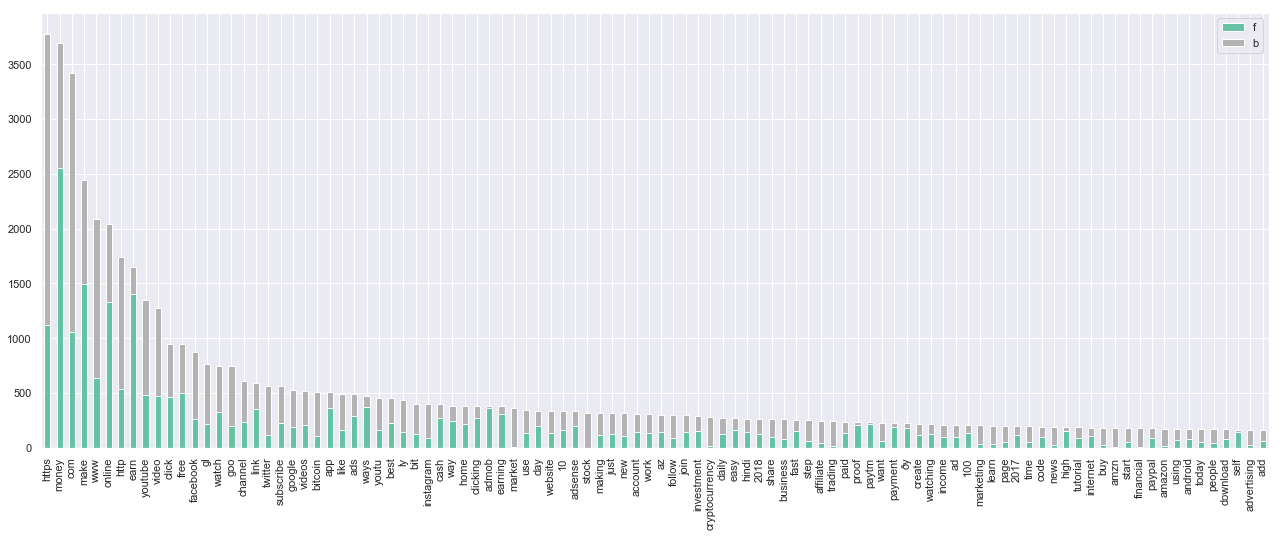

In [233]:
top_n = 100
(full_df[:top_n]
 .drop('overall', axis=1)
 .plot(kind='bar', stacked=True, 
       colormap='Set2', figsize=(22,8)));
# plt.gca().invert_yaxis()
# plt.legend(loc='upper right');

### tags

In [220]:
def get_all_tags(series):
    all_tags = []
    all_tags.extend(series.values)
    all_tags = [item for sublist in all_tags for item in sublist]
    return all_tags

In [228]:
b_tags = get_all_tags(df[df['classification'] == 'b']['tags'])
f_tags = get_all_tags(df[df['classification'] == 'f']['tags'])
all_tags = get_all_tags(df['tags'])

In [223]:
def tags_count_df(tags):
    tags_c = Counter(tags)
    tags_df = pd.DataFrame.from_dict(tags_c, orient='index')
    tags_df.columns = ['count']
    tags_df.sort_values('count', ascending=False, inplace=True)
    return tags_df

In [234]:
full_df = pd.concat([tags_count_df(all_tags),
                     tags_count_df(f_tags),
                     tags_count_df(b_tags)], axis=1, sort=True)
full_df.columns = ['overall', 'f', 'b']
full_df.sort_values('overall', ascending=False, inplace=True)
full_df.head()

,overall,f,b
make money online,114,63.0,51.0
,98,60.0,38.0
how to make money online,98,46.0,52.0
N,98,60.0,38.0
o,98,60.0,38.0


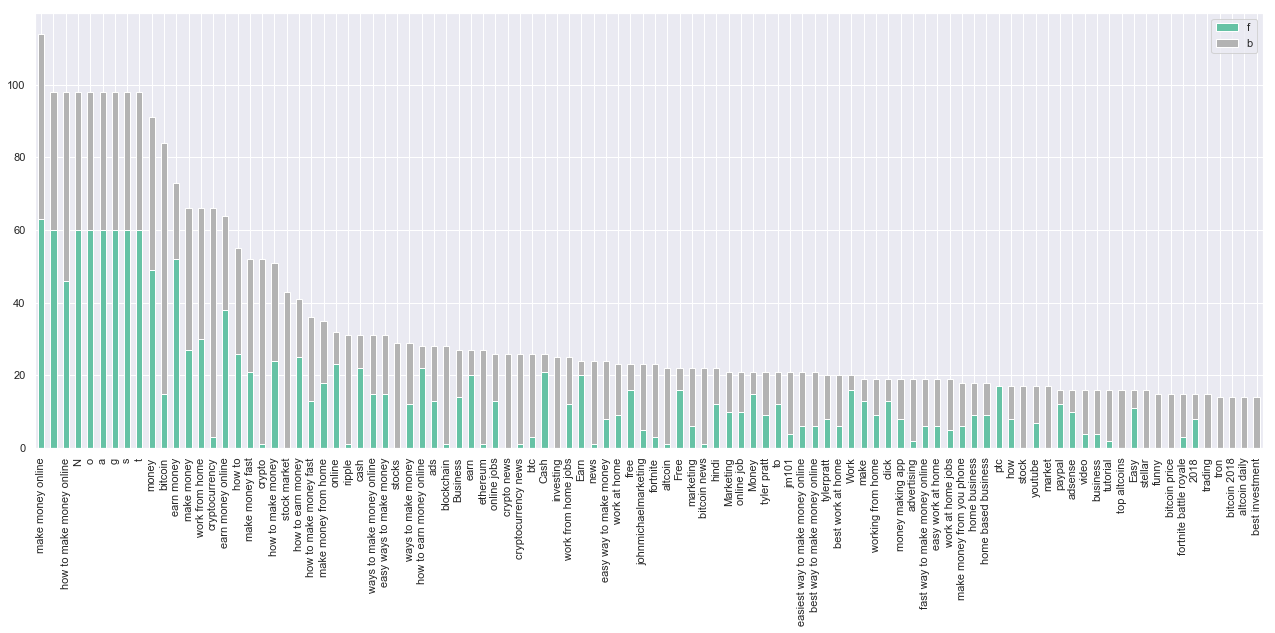

In [235]:
top_n = 100
(full_df[:top_n]
 .drop('overall', axis=1)
 .plot(kind='bar', stacked=True, 
       colormap='Set2', figsize=(22,8)));